In [1]:
import numpy as np
from numpy.matlib import repmat
import pandas as pd
import pingouin as pg
import scipy.io as sio
import EEG_Decoder.eeg_decoder as eeg_decoder
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none' # change svg font type from path to text
import seaborn as sns

from mne.filter import filter_data
from scipy.signal import hilbert
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

from utils import clean_behavior, setup_hyperplane_conds

from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
np.random.seed(2023)

In [3]:
experiment_name = 'DATA/Preprocessed'
data_dir = f'../../{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
exp.behavior_files = sorted(list(exp.data_dir.glob('*.csv')))

In [4]:
full_times = np.arange(-650, 1650, 2)
tois = np.arange(-250, 1250, 2)
times_bool = [1 if (t in tois) else 0 for t in full_times]
censor_times = full_times >= 1250 # values to convert to 0 to prevent leak backwards

In [5]:
time_window = 25
time_step = 25
trial_bin_size = 1
n_splits = 100
group_dict = {}

wrangl = eeg_decoder.Wrangler(tois,time_window,time_step,trial_bin_size,n_splits,group_dict)
wrangl.t

array([-250, -226, -202, -178, -154, -130, -106,  -82,  -58,  -34,  -10,
         14,   38,   62,   86,  110,  134,  158,  182,  206,  230,  254,
        278,  302,  326,  350,  374,  398,  422,  446,  470,  494,  518,
        542,  566,  590,  614,  638,  662,  686,  710,  734,  758,  782,
        806,  830,  854,  878,  902,  926,  950,  974,  998, 1022, 1046,
       1070, 1094, 1118, 1142, 1166, 1190, 1214])

## Helpers

In [6]:
def makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx):
    assert len(Cond1Idx)==len(Cond2Idx) and len(posLabels)==len(Cond1Idx)
    
    nTrials = len(Cond1Idx); 
    blocks = np.full((nTrials), np.nan)
    
    C1_posLabels = posLabels[Cond1Idx]
    C2_posLabels = posLabels[Cond2Idx]
    
    binCnt = np.full((2, nBins), np.nan)
    for b in range(nBins):
        binCnt[0,b] = np.sum(C1_posLabels == b+1)
        binCnt[1,b] = np.sum(C2_posLabels == b+1)

    minCnt = np.min(binCnt)
    nPerBin = int(np.floor(minCnt/nBlocks))
    
    
    for c in [1, 2]:
        pBin = C1_posLabels if c==1 else C2_posLabels

        tmp_nTrials = len(pBin)
        shuffBlocks = np.full(pBin.shape, np.nan)

        # shuffle trials
        shuffInd = np.arange(tmp_nTrials)
        np.random.shuffle(shuffInd)
        shuffBin = pBin[shuffInd] # shuffle trial order

        # take the 1st nPerBin x nBlocks trials for each position bin.
        for b in range(nBins):
            idx = np.where(shuffBin == b+1)[0]  # get index for trials belonging to the current bin
            idx = idx[:nPerBin*nBlocks]  # drop excess trials
            x = repmat(np.arange(1, nBlocks+1), 1, nPerBin)
            shuffBlocks[idx] = x # assign trials to blocks

        if c==1:
            C1_Blocks = np.full(C1_posLabels.shape, np.nan)
            C1_Blocks[shuffInd] = shuffBlocks
        elif c==2:
            C2_Blocks = np.full(C2_posLabels.shape, np.nan)
            C2_Blocks[shuffInd] = shuffBlocks


    ## regular blocks is just two condLabels combined
    blocks[Cond1Idx] = C1_Blocks
    blocks[Cond2Idx] = C2_Blocks
    nTrialsPerBlock = np.sum(blocks==1) # of trials per block
    nTrialsPerBlock_C1 = np.sum(blocks[Cond1Idx]==1)
    nTrialsPerBlock_C2 = np.sum(blocks[Cond2Idx]==1)
    
    return(blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2)

In [7]:
def MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x):
    prediction = np.sin(0.5*x)**sinPower
    prediction = np.roll(prediction, 4, axis=0)
    basisSet = np.full((nChans, nBins), np.nan)
    basisSet[0, :] = prediction
    for c in range(1, nChans):
        basisSet[c, :] = prediction = np.roll(prediction, 1, axis=0)
    return(basisSet)

In [8]:
def center_CTFs(ctf):
    # assumes the shape of the CTF matrix is nLocations x nChannels
        
    ctf_aligned = ctf.copy()
    nrows = ctf.shape[0]
    for s in range(nrows):
        ctf_aligned[s, :] = np.roll(ctf[s, :], -s) # align the centers to the first column
            
    return(np.roll(ctf_aligned, int(np.ceil(nrows/2)), axis=1)) # shift to center

def center_and_mean_CTF(ctf):
    ctf_aligned = center_CTFs(ctf)
    return(np.mean(ctf_aligned, 0))
        
    # ctf_aligned = ctf.copy()
    # nrows = ctf.shape[0]
    # for s in range(nrows):
    #     ctf_aligned[s, :] = np.roll(ctf[s, :], -s) # align the centers to the first column
        
    # mean_ctf = np.mean(ctf_aligned, 0) # average across the rows (posLabels)
    
    # return(np.roll(mean_ctf, int(np.ceil(nrows/2)))) # shift to center

def CTF_Slope(ctf):
    x = [1, 2, 3, 4, 5]
    y = [ctf[0], ctf[[1,7]].mean(), ctf[[2,6]].mean(), ctf[[3,5]].mean(), ctf[4]]
    return(np.polyfit(x, y, deg=1)[0]) # fit and get slope

In [9]:
def IEM_2cond(totalPower, posLabels, condLabels, times_bool, held_out=None, sinPower=25, nBins=8, nChans=8, nIter=100, nBlocks=3, freq_bounds=[8, 12], time = tois, Fs=500, wrangl=wrangl):
    # ARGUMENTS
    # totalPower = Alpha power of EEG data of shape nTrials, nElectrodes, nTimePoints
    # posLabels = list of spatial positions (in terms of bin number) for each trial
    # condLabels = list of condition labels (1 or 2) for each trial
    # sinPower = power of the response function 
    # nBins = num location bins
    # nChans = num channels (cell popluations)
    # nIter =  num iterations (input to function)
    # nBlocks = num blocks for cross-validation
    # freq_bounds = frequency range to analyze 
    # nSamps = num time points of interest
    # Fs = Sampling rate of EEG

    nSamps = len(time)
    nTrials = len(posLabels)
    nElectrodes = totalPower.shape[1]
    
    x = np.linspace(0, 2*np.pi-2*np.pi/nBins, nBins)
    basisSet = MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x)
    
    Cond1Idx = condLabels==1
    Cond2Idx = condLabels==2
    
    # Preallocate Output Matrices
    tf_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    sl_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    if held_out is not None:
        tf_held_out = defaultdict(lambda : np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan))
        sl_held_out = defaultdict(lambda : np.full((nIter,len(wrangl.t),nBlocks), np.nan))
    
    
    blocks = np.full((nTrials,nIter), np.nan)
    
    ## Filter and Organize Data into Blocks
    totalPower = np.squeeze(totalPower[:, :, np.where(times_bool)]) # subset to times-of-interest
    assert totalPower.shape[2]==nSamps
    
    ## create block assignments
    for i in range(nIter):
        (curr_blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2) = makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx);
        blocks[:,i] = curr_blocks
        
    tmpBlocks = blocks.copy()
    
    for i in range(nIter):
        curr_blocks = tmpBlocks[:,i]
        
        # Preallocate
        blockDat_total = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond1 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond2 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)

        labels = np.full((nBins*nBlocks), np.nan)
        blockNum = np.full((nBins*nBlocks), np.nan)
        c = np.full((nBins*nBlocks, nChans), np.nan)

        # Average data for each bin across blocks
        counter = 0
        for j in range(nBins):
            for k in range(nBlocks):
                # all data for training
                blockDat_total[counter,:,:] = np.mean(totalPower[(posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond1 Test
                blockDat_total_Cond1[counter,:,:] = np.mean(totalPower[(Cond1Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond2 Test
                blockDat_total_Cond2[counter,:,:] = np.mean(totalPower[(Cond2Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)

                # info
                labels[counter] = j
                blockNum[counter] = k
                c[counter,:] = basisSet[j,:]
                counter+=1

        # run IEM on each timepoint
        for t in range(len(wrangl.t)):
            time_window_idx = (wrangl.samples >= wrangl.t[t]) & (
                wrangl.samples < wrangl.t[t] + wrangl.time_window)
            
            dt = np.mean(blockDat_total[:, :, time_window_idx], 2)
            dt_Cond1 = np.mean(blockDat_total_Cond1[:,:,time_window_idx], 2)
            dt_Cond2 = np.mean(blockDat_total_Cond2[:,:,time_window_idx], 2)
            if held_out is not None:
                dt_heldOut = {}
                for heldOutCond in held_out:
                    dt_heldOut[heldOutCond] = np.mean(held_out[heldOutCond][:,:,time_window_idx], 2)
            

            for b in range(nBlocks): # hold out each block as the test set, train on the other 2
                train_labels = labels[blockNum!=b]
                test_labels = labels[blockNum==b]

                C1 = c[blockNum!=b, :]
                B1 = dt[blockNum!=b, :]
                B2_Cond1 = dt_Cond1[blockNum==b, :]
                B2_Cond2 = dt_Cond2[blockNum==b, :]

                # fit model and record res
                channel_weights = np.linalg.lstsq(C1, B1, rcond=None)[0]
                recon1 = np.linalg.lstsq(channel_weights.T , B2_Cond1.T, rcond=None)[0].T
                ctf_Cond1 = center_and_mean_CTF(recon1)
                
                recon2 = np.linalg.lstsq(channel_weights.T , B2_Cond2.T, rcond=None)[0].T
                ctf_Cond2 = center_and_mean_CTF(recon2)
                
                tf_total_Cond1[i,t,b,:] = ctf_Cond1
                tf_total_Cond2[i,t,b,:] = ctf_Cond2
                
                # save the slopes
                sl_total_Cond1[i,t,b] = CTF_Slope(ctf_Cond1) 
                sl_total_Cond2[i,t,b] = CTF_Slope(ctf_Cond2)
                
                # save held out conditions
                if held_out is not None:
                    for heldOutCond in held_out:
                        recon_heldOut = np.linalg.lstsq(channel_weights.T , dt_heldOut[heldOutCond].T, rcond=None)[0].T
                        ctf_heldOut = center_and_mean_CTF(recon_heldOut)
                        tf_held_out[heldOutCond][i,t,b] = ctf_heldOut
                        sl_held_out[heldOutCond][i,t,b] = CTF_Slope(ctf_heldOut)
                        

    if held_out is not None:           
        return {
            'tuneFuncs':{
                'Cond1': tf_total_Cond1,
                'Cond2': tf_total_Cond2,
                'held_out': tf_held_out
            },
            'slope':{
                'Cond1': sl_total_Cond1,
                'Cond2': sl_total_Cond2,
                'held_out': sl_held_out
            },     
        }
    else:
        return {
            'tuneFuncs':{
                'Cond1': tf_total_Cond1,
                'Cond2': tf_total_Cond2
            },
            'slope':{
                'Cond1': sl_total_Cond1,
                'Cond2': sl_total_Cond2
            },     
        }

# clean up data

In [10]:
xdata_dict = {}
behavior_dict = {}

for isub in range(exp.nsub):
    xdata,_ = exp.load_eeg(isub)
    xdata[:,:,censor_times] = 0 # censor timepoints to prevent bleeding backwards
    
    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()
    
    behavior = pd.read_csv(exp.behavior_files[isub])
    behavior = clean_behavior(behavior, noArt_idx, isub)    
    assert len(behavior)==xdata.shape[0]
    
    # drop interruption trials for subs 4,5
    no_interruption_trials = (behavior.port_codes < 240).values
    behavior = behavior[no_interruption_trials].reset_index(drop=True)
    xdata = xdata[no_interruption_trials, :, :]
    
    # match nDots across loads
    behavior = behavior.query('total_nDots >= 24')
    xdata = xdata[behavior.index.values, :, :]
    behavior = behavior.reset_index(drop=True)
    
    xdata_dict[isub] = np.abs(hilbert(filter_data(xdata.astype(np.float64), 500, 8, 12)))**2 # convert to alpha power
    behavior_dict[isub] = setup_hyperplane_conds(behavior)



Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


# Visualization Helpers

In [11]:
hyperplane_conds = {
    0: 'SS1: Narrow',
    1: 'SS1: Broad',
    2: 'SS2: Overlap, Narrow',
    3: 'SS2: Overlap, Broad',
    4: 'SS2: Superset Overlap',
    5: 'SS2: Partial Overlap',
    6: 'SS2: No Overlap, Mixed',
    7: 'SS2: No Overlap, Narrow',
    8: 'SS2: No Overlap, Broad'
}

cond_load_map = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1} # mapping the conditions to loads

colormap = {
    0: 'royalblue',
    1: 'forestgreen',
    2: 'indigo',
    3: 'coral',
    4: 'orange',
    5: 'red',
    6: 'maroon',
    7: 'yellow',
    8: 'dodgerblue'
}

palette={hyperplane_conds[idx]: colormap[idx] for idx in range(9)}
palette

{'SS1: Narrow': 'royalblue',
 'SS1: Broad': 'forestgreen',
 'SS2: Overlap, Narrow': 'indigo',
 'SS2: Overlap, Broad': 'coral',
 'SS2: Superset Overlap': 'orange',
 'SS2: Partial Overlap': 'red',
 'SS2: No Overlap, Mixed': 'maroon',
 'SS2: No Overlap, Narrow': 'yellow',
 'SS2: No Overlap, Broad': 'dodgerblue'}

In [12]:
def make_slope_df(results, isub, cond, condname, time=wrangl.t):
    sub_slopes = pd.DataFrame()
    sub_slopes['time'] = time + 12.5 # center the time window
    sub_slopes['Slope'] = results[isub]['slope'][cond].mean(0).mean(1)
    sub_slopes['PID'] = isub
    sub_slopes['condition'] = condname
    return(sub_slopes)

In [13]:
def make_CTF_df(results_dict, isub, cond, condname, wrangl=wrangl):
    sub_CTFs = pd.DataFrame()
    # mean across iterations, blocks, ignore the first 500ms before meaning across time
    sub_CTFs['Response'] = results_dict[isub]['tuneFuncs'][cond].mean(0).mean(1)[wrangl.t > 250, :].mean(0)
    sub_CTFs['Channel'] = np.arange(1,9)
    sub_CTFs['PID'] = isub
    sub_CTFs['condition'] = condname
    return(sub_CTFs)

In [14]:
def plot_results(results_dict, cond1, cond2, figname=None, **kws):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # SLOPE RESULTS
    slope_df_width = pd.DataFrame()
    for isub in range(exp.nsub):
        sub_slopes_obs = pd.concat([make_slope_df(results_dict, isub, 'Cond1', cond1),
               make_slope_df(results_dict, isub, 'Cond2', cond2)])

        slope_df_width = pd.concat([slope_df_width, sub_slopes_obs])

    slope_df_width = slope_df_width.reset_index(drop=True)

    _ = ax.fill_between([0, 250],[-.02,-.02],[.15,.15],color='gray',alpha=.5)
    _ = ax.axhline(y=0, color='k', linestyle='--', linewidth=2)
    ax = sns.lineplot(x='time', y='Slope', hue='condition', data=slope_df_width, ax=ax, **kws)
    plt.ylim([-.02, .15])
    plt.xlim([-250+12.5, 1250-12.5])
    if figname is not None:
        plt.tight_layout()
        plt.savefig(f'RawFigures/{figname}_slopesAcrossTime.svg')    
    plt.show()
    plt.close()
    
    # # SLOPE DIFFERENCE
    # difference_df = slope_df_width.query(f'condition=="{cond1}"')[['time', 'Slope', 'PID']].reset_index(drop=True).sub(slope_df_width.query(f'condition=="{cond2}"')[['time', 'Slope', 'PID']].reset_index(drop=True))
    # # assertions that the subtractions happened at the same time, subject
    # all(difference_df.time.unique()==0)
    # all(difference_df.PID.unique()==0)
    # # replace with useful values 
    # difference_df.time = slope_df_width.query(f'condition=="{cond1}"').time.values
    # difference_df.PID = slope_df_width.query(f'condition=="{cond1}"').PID.values
    # difference_df['method'] = slope_df_width.query(f'condition=="{cond1}"').method.values

    # ax = sns.lineplot(x='time', y='Slope', style='method', data=difference_df, ax=axes[1])
    # _ = ax.axhline(y=0, color='k', linestyle='--', linewidth=2)
    # plt.show()
    # plt.close()
    
    # CTF RESULTS - separate figure
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    CTF_df = pd.DataFrame()
    for isub in range(exp.nsub):
        sub_CTFs_obs = pd.concat([make_CTF_df(results_dict, isub, 'Cond1', cond1),
               make_CTF_df(results_dict, isub, 'Cond2', cond2)])
        sub_CTFs_obs['method'] = 'Observed'
        
        CTF_df = pd.concat([CTF_df, sub_CTFs_obs])

    CTF_df = CTF_df.reset_index(drop=True)
    
    wraparound = CTF_df.query('Channel==1').copy()
    wraparound['Channel'] = 9
    CTF_df = pd.concat([CTF_df, wraparound]).reset_index(drop=True)

    ax = sns.lineplot(x='Channel', y='Response', hue='condition', data=CTF_df, err_style='bars', ax=axes, **kws)
    ax.set_xticks(np.arange(1, 10))
    ax.set_xticklabels(np.linspace(-180, 180, 9))
    if figname is not None:
        plt.tight_layout()
        plt.savefig(f'RawFigures/{figname}_CTF.svg')
    plt.show()
    plt.close()

In [15]:
def compare_delay_slopes(results_dict, cond1, cond2, alternative='two-sided', figname=None, first_t=250, last_t=1150, ttest=True, return_summary=False, **kws):

    # SLOPE RESULTS
    slope_df_width = pd.DataFrame()
    for isub in range(exp.nsub):
        sub_slopes_obs = pd.concat([make_slope_df(results_dict, isub, 'Cond1', cond1),
               make_slope_df(results_dict, isub, 'Cond2', cond2)])

        slope_df_width = pd.concat([slope_df_width, sub_slopes_obs])

    slope_df_width = slope_df_width.reset_index(drop=True)


    summary = slope_df_width.query(f'(time > {first_t}) & (time <= {last_t})').groupby(['PID', 'condition']).mean().reset_index()
    ax = sns.barplot(x='condition', y='Slope', data=summary, **kws)
    ax.set_ylim([0, .125])
    ax.set_yticks(np.arange(0, .125, .025))
    ax.set_yticklabels(np.round(np.arange(0, .125, .025), 3))
    
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    
    if figname is not None:
        plt.tight_layout()
        plt.savefig(f'RawFigures/{figname}_bar.svg')
    plt.show()
    diffs = summary.query(f'condition=="{cond1}"')['Slope'].values - summary.query(f'condition=="{cond2}"')['Slope'].values
    _ = sns.barplot(x=diffs)
    plt.show()
    plt.close()

    if ttest:
        print(pg.pairwise_tests(dv='Slope', within='condition', subject='PID', data=summary, effsize='cohen'))

    ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
    ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)
    ax = sns.stripplot(x='condition', y='Slope', data=summary, jitter=False, hue='condition', s=10, edgecolor='k', linewidth=1, **kws)
    
    ax.set_ylim([0, .23])
    # ax.set_xlim([-.15, 1.15])
    ax.set_yticks(np.arange(0, .25, .05))
    # ax.set_yticklabels(np.round(np.arange(0, .2, .025), 3))

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    _ = ax.set_xlabel('')

    if figname is not None:
        plt.tight_layout()
        plt.savefig(f'RawFigures/{figname}_lines.svg')
    plt.show()
    plt.close()

    if return_summary:
        return summary

In [16]:
def compare_slopes_across_delay_halves(results, cond1, cond2, alternative='two-sided', figname=None, **kws):
    if figname is None:
        figname1 = None
        figname2 = None
    else:
        figname1 = figname + '_firstHalf'
        figname2 = figname + '_lastHalf'
    first_half_summary = compare_delay_slopes(results, cond1, cond2, alternative=alternative, figname=figname1, last_t=700, ttest=False, return_summary=True, **kws)
    first_half_summary['delay_half'] = 'first'
    last_half_summary = compare_delay_slopes(results, cond1, cond2, alternative=alternative, figname=figname2, first_t=700, ttest=False, return_summary=True, **kws)
    last_half_summary['delay_half'] = 'last'
    
    split_half_summary = pd.concat([first_half_summary, last_half_summary])

    aov = pg.rm_anova(dv='Slope', within=['condition', 'delay_half'], subject='PID', data=split_half_summary, detailed=True, effsize='ng2')
    # run post-hocs if significant interaction
    post_hocs = None
    if aov.loc[2, 'p-GG-corr'] < .05:
        post_hocs = pg.pairwise_ttests(dv='Slope', within=['condition', 'delay_half'], subject='PID', data=split_half_summary, padjust='none', return_desc=True).loc[2:, :]
        post_hocs = pd.concat([post_hocs, pg.pairwise_ttests(dv='Slope', within=['delay_half', 'condition'], subject='PID', data=split_half_summary, padjust='none', return_desc=True).loc[2:, :]])
        post_hocs['p-corr']  = multipletests(post_hocs['p-unc'].values, method='fdr_bh')[1] # benjamini-hochberg corrected p-values

    return aov, post_hocs, split_half_summary

# Set Size 1 vs Set Size 2

In [17]:
np.random.seed(2023)

In [18]:
ss_results = {}
for isub in range(exp.nsub):
    xdata = xdata_dict[isub]
    behavior = behavior_dict[isub]
    
    posLabels = behavior.targetBin.values        
    condLabels = behavior.SetSize.values
    print(isub, Counter(condLabels))
    
    ss_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool)

0 Counter({2: 697, 1: 459})
1 Counter({2: 753, 1: 488})
2 Counter({2: 693, 1: 462})
3 Counter({2: 651, 1: 462})
4 Counter({2: 712, 1: 484})
5 Counter({2: 706, 1: 522})
6 Counter({2: 565, 1: 371})
7 Counter({2: 755, 1: 516})
8 Counter({2: 665, 1: 433})
9 Counter({2: 705, 1: 474})
10 Counter({2: 703, 1: 468})
11 Counter({2: 626, 1: 417})
12 Counter({2: 747, 1: 499})
13 Counter({2: 708, 1: 465})
14 Counter({2: 747, 1: 536})
15 Counter({2: 627, 1: 431})
16 Counter({2: 643, 1: 456})
17 Counter({2: 726, 1: 511})
18 Counter({2: 737, 1: 490})
19 Counter({2: 715, 1: 486})
20 Counter({2: 713, 1: 450})
21 Counter({2: 748, 1: 534})
22 Counter({2: 696, 1: 464})


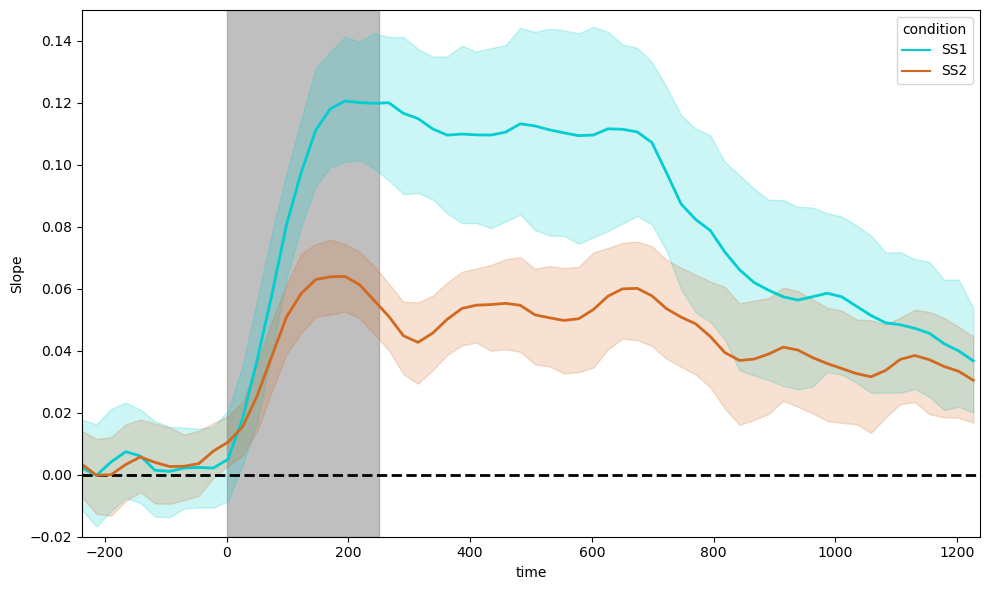

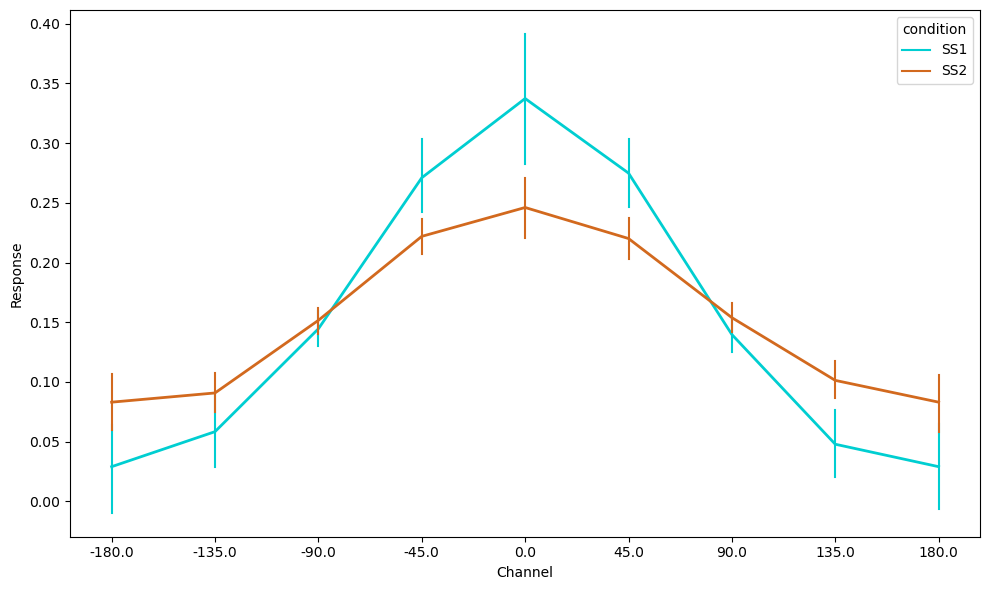

In [19]:
plot_results(ss_results, 'SS1', 'SS2', figname='IEM_setSize', palette={'SS1': 'darkturquoise', 'SS2': 'chocolate'}, linewidth=2)

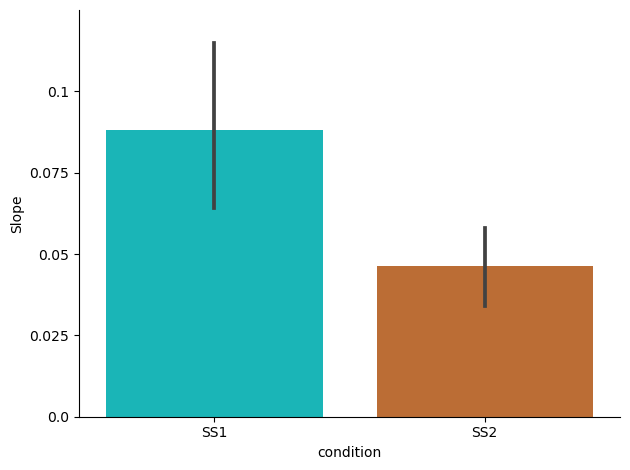

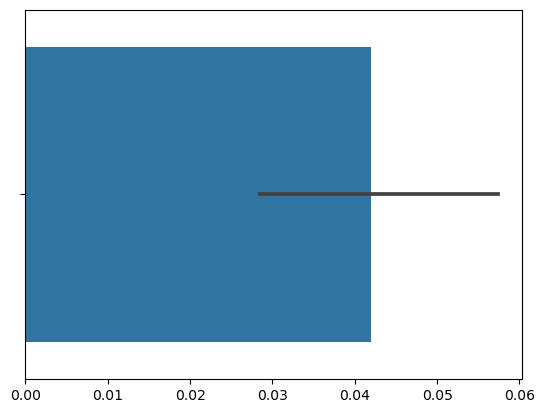

    Contrast    A    B  Paired  Parametric         T   dof alternative  \
0  condition  SS1  SS2    True        True  5.690675  22.0   two-sided   

     p-unc      BF10     cohen  
0  0.00001  2165.308  0.867826  


/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


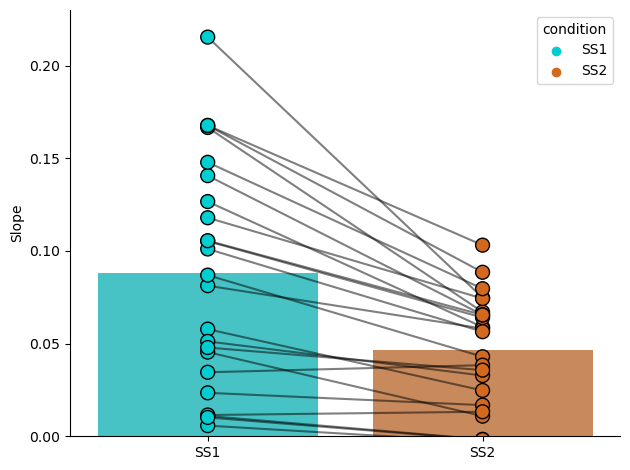

In [20]:
compare_delay_slopes(ss_results, 'SS1', 'SS2', alternative='two-sided', figname='IEM_setSize', palette={'SS1': 'darkturquoise', 'SS2': 'chocolate'})

# Set Size 1 - Narrow vs Broad Target

In [21]:
np.random.seed(2023)

In [22]:
width_results = {}
for isub in range(exp.nsub):
    xdata = xdata_dict[isub]
    behavior = behavior_dict[isub]
    
    # subset to set size 1
    xdata = xdata[behavior.SetSize==1, :, :]
    behavior = behavior.loc[behavior.SetSize==1]
    
    posLabels = behavior.targetBin.values
    condLabels = np.where(behavior.targetWidth==1, 1, 2)
    print(Counter(condLabels))
    
    width_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool)

Counter({1: 232, 2: 227})
Counter({2: 255, 1: 233})
Counter({2: 243, 1: 219})
Counter({1: 238, 2: 224})
Counter({1: 249, 2: 235})
Counter({1: 263, 2: 259})
Counter({2: 192, 1: 179})
Counter({1: 259, 2: 257})
Counter({2: 222, 1: 211})
Counter({1: 241, 2: 233})
Counter({1: 235, 2: 233})
Counter({2: 217, 1: 200})
Counter({2: 253, 1: 246})
Counter({2: 238, 1: 227})
Counter({1: 278, 2: 258})
Counter({2: 218, 1: 213})
Counter({2: 240, 1: 216})
Counter({1: 264, 2: 247})
Counter({2: 253, 1: 237})
Counter({2: 247, 1: 239})
Counter({1: 228, 2: 222})
Counter({1: 268, 2: 266})
Counter({2: 239, 1: 225})


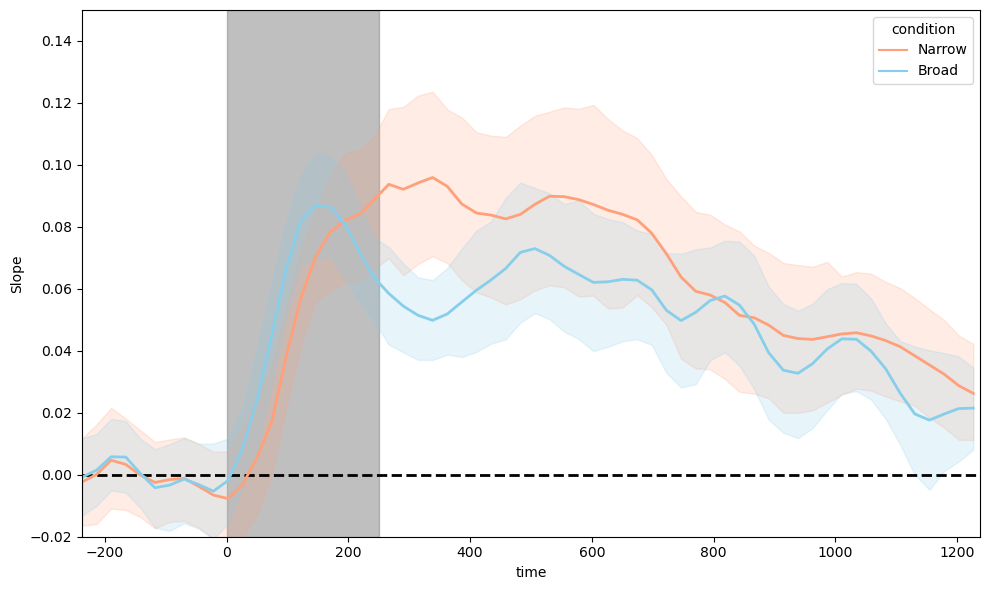

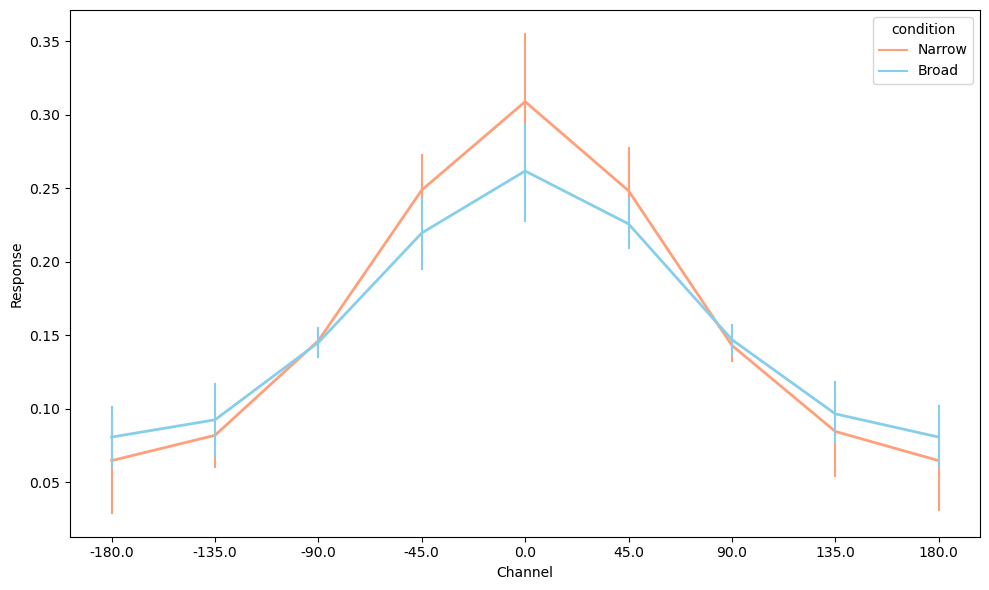

In [23]:
plot_results(width_results, 'Narrow', 'Broad', figname='IEM_SS1Breadth', palette={'Narrow': 'lightsalmon', 'Broad': 'skyblue'}, linewidth=2)

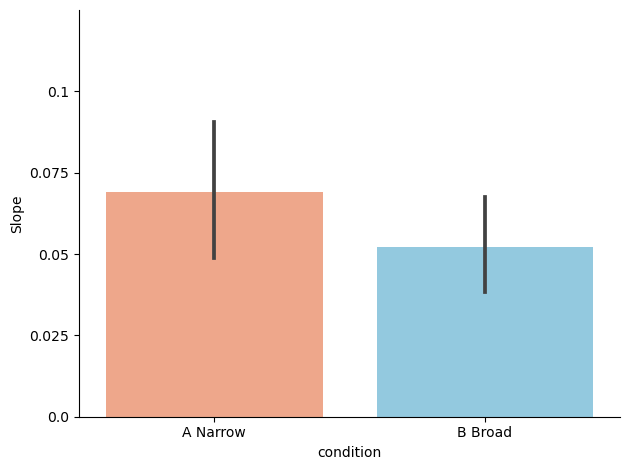

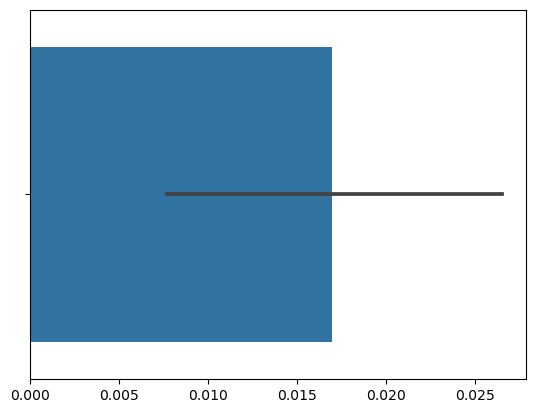

    Contrast         A        B  Paired  Parametric         T   dof  \
0  condition  A Narrow  B Broad    True        True  3.313401  22.0   

  alternative    p-unc    BF10    cohen  
0   two-sided  0.00316  13.057  0.38106  


/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


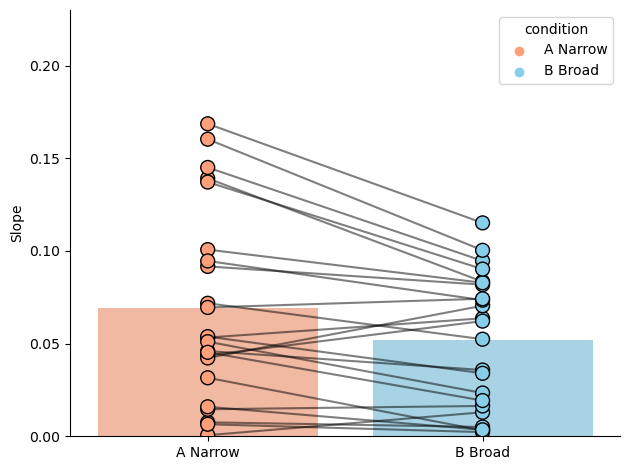

In [24]:
compare_delay_slopes(width_results, 'A Narrow', 'B Broad', figname='IEM_SS1Breadth', palette={'A Narrow': 'lightsalmon', 'B Broad': 'skyblue'})

## Plot by locations
### compare slopes for broad clouds that straddled hemifields against those that were lateralized

In [25]:
def IEM_2cond_noCentering(totalPower, posLabels, condLabels, times_bool, held_out=None, sinPower=25, nBins=8, nChans=8, nIter=100, nBlocks=3, freq_bounds=[8, 12], time = tois, Fs=500, wrangl=wrangl):
    # ARGUMENTS
    # totalPower = Alpha power of EEG data of shape nTrials, nElectrodes, nTimePoints
    # posLabels = list of spatial positions (in terms of bin number) for each trial
    # condLabels = list of condition labels (1 or 2) for each trial
    # sinPower = power of the response function 
    # nBins = num location bins
    # nChans = num channels (cell popluations)
    # nIter =  num iterations (input to function)
    # nBlocks = num blocks for cross-validation
    # freq_bounds = frequency range to analyze 
    # nSamps = num time points of interest
    # Fs = Sampling rate of EEG

    nSamps = len(time)
    nTrials = len(posLabels)
    nElectrodes = totalPower.shape[1]
    
    x = np.linspace(0, 2*np.pi-2*np.pi/nBins, nBins)
    basisSet = MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x)
    
    Cond1Idx = condLabels==1
    Cond2Idx = condLabels==2
    
    # Preallocate Output Matrices
    tf_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks,nChans,nChans), np.nan)
    tf_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks,nChans,nChans), np.nan)
    # sl_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    # sl_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    if held_out is not None:
        tf_held_out = defaultdict(lambda : np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan))
        sl_held_out = defaultdict(lambda : np.full((nIter,len(wrangl.t),nBlocks), np.nan))
    
    
    blocks = np.full((nTrials,nIter), np.nan)
    
    ## Filter and Organize Data into Blocks
    totalPower = np.squeeze(totalPower[:, :, np.where(times_bool)]) # subset to times-of-interest
    assert totalPower.shape[2]==nSamps
    
    ## create block assignments
    for i in range(nIter):
        (curr_blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2) = makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx);
        blocks[:,i] = curr_blocks
        
    tmpBlocks = blocks.copy()
    
    for i in range(nIter):
        curr_blocks = tmpBlocks[:,i]
        
        # Preallocate
        blockDat_total = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond1 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond2 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)

        labels = np.full((nBins*nBlocks), np.nan)
        blockNum = np.full((nBins*nBlocks), np.nan)
        c = np.full((nBins*nBlocks, nChans), np.nan)

        # Average data for each bin across blocks
        counter = 0
        for j in range(nBins):
            for k in range(nBlocks):
                # all data for training
                blockDat_total[counter,:,:] = np.mean(totalPower[(posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond1 Test
                blockDat_total_Cond1[counter,:,:] = np.mean(totalPower[(Cond1Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond2 Test
                blockDat_total_Cond2[counter,:,:] = np.mean(totalPower[(Cond2Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)

                # info
                labels[counter] = j
                blockNum[counter] = k
                c[counter,:] = basisSet[j,:]
                counter+=1

        # run IEM on each timepoint
        for t in range(len(wrangl.t)):
            time_window_idx = (wrangl.samples >= wrangl.t[t]) & (
                wrangl.samples < wrangl.t[t] + wrangl.time_window)
            
            dt = np.mean(blockDat_total[:, :, time_window_idx], 2)
            dt_Cond1 = np.mean(blockDat_total_Cond1[:,:,time_window_idx], 2)
            dt_Cond2 = np.mean(blockDat_total_Cond2[:,:,time_window_idx], 2)
            if held_out is not None:
                dt_heldOut = {}
                for heldOutCond in held_out:
                    dt_heldOut[heldOutCond] = np.mean(held_out[heldOutCond][:,:,time_window_idx], 2)
            

            for b in range(nBlocks): # hold out each block as the test set, train on the other 2
                train_labels = labels[blockNum!=b]
                test_labels = labels[blockNum==b]

                C1 = c[blockNum!=b, :]
                B1 = dt[blockNum!=b, :]
                B2_Cond1 = dt_Cond1[blockNum==b, :]
                B2_Cond2 = dt_Cond2[blockNum==b, :]

                # fit model and record res
                channel_weights = np.linalg.lstsq(C1, B1, rcond=None)[0]
                recon1 = np.linalg.lstsq(channel_weights.T , B2_Cond1.T, rcond=None)[0].T
                # ctf_Cond1 = center_and_mean_CTF(recon1)
                
                recon2 = np.linalg.lstsq(channel_weights.T , B2_Cond2.T, rcond=None)[0].T
                # ctf_Cond2 = center_and_mean_CTF(recon2)
                
                tf_total_Cond1[i,t,b,:,:] = recon1
                tf_total_Cond2[i,t,b,:,:] = recon2
                
                # save the slopes
                # sl_total_Cond1[i,t,b] = CTF_Slope(ctf_Cond1) 
                # sl_total_Cond2[i,t,b] = CTF_Slope(ctf_Cond2)
                
                # save held out conditions
                if held_out is not None:
                    for heldOutCond in held_out:
                        recon_heldOut = np.linalg.lstsq(channel_weights.T , dt_heldOut[heldOutCond].T, rcond=None)[0].T
                        ctf_heldOut = center_and_mean_CTF(recon_heldOut)
                        tf_held_out[heldOutCond][i,t,b] = ctf_heldOut
                        sl_held_out[heldOutCond][i,t,b] = CTF_Slope(ctf_heldOut)
                        

    if held_out is not None:           
        return {
            'tuneFuncs':{
                'Cond1': tf_total_Cond1,
                'Cond2': tf_total_Cond2,
                'held_out': tf_held_out
            },
            # 'slope':{
            #     'Cond1': sl_total_Cond1,
            #     'Cond2': sl_total_Cond2,
            #     'held_out': sl_held_out
            # },     
        }
    else:
        return {
            'tuneFuncs':{
                'Cond1': tf_total_Cond1,
                'Cond2': tf_total_Cond2
            },
            # 'slope':{
            #     'Cond1': sl_total_Cond1,
            #     'Cond2': sl_total_Cond2
            # },     
        }

In [26]:
np.random.seed(2023)

In [27]:
width_results_noCentering = {}
for isub in range(exp.nsub):
    xdata = xdata_dict[isub]
    behavior = behavior_dict[isub]
    
    # subset to set size 1
    xdata = xdata[behavior.SetSize==1, :, :]
    behavior = behavior.loc[behavior.SetSize==1]
    
    posLabels = behavior.targetBin.values
    condLabels = np.where(behavior.targetWidth==1, 1, 2)
    print(Counter(condLabels))
    
    width_results_noCentering[isub] = IEM_2cond_noCentering(xdata, posLabels, condLabels, times_bool)

Counter({1: 232, 2: 227})
Counter({2: 255, 1: 233})
Counter({2: 243, 1: 219})
Counter({1: 238, 2: 224})
Counter({1: 249, 2: 235})
Counter({1: 263, 2: 259})
Counter({2: 192, 1: 179})
Counter({1: 259, 2: 257})
Counter({2: 222, 1: 211})
Counter({1: 241, 2: 233})
Counter({1: 235, 2: 233})
Counter({2: 217, 1: 200})
Counter({2: 253, 1: 246})
Counter({2: 238, 1: 227})
Counter({1: 278, 2: 258})
Counter({2: 218, 1: 213})
Counter({2: 240, 1: 216})
Counter({1: 264, 2: 247})
Counter({2: 253, 1: 237})
Counter({2: 247, 1: 239})
Counter({1: 228, 2: 222})
Counter({1: 268, 2: 266})
Counter({2: 239, 1: 225})


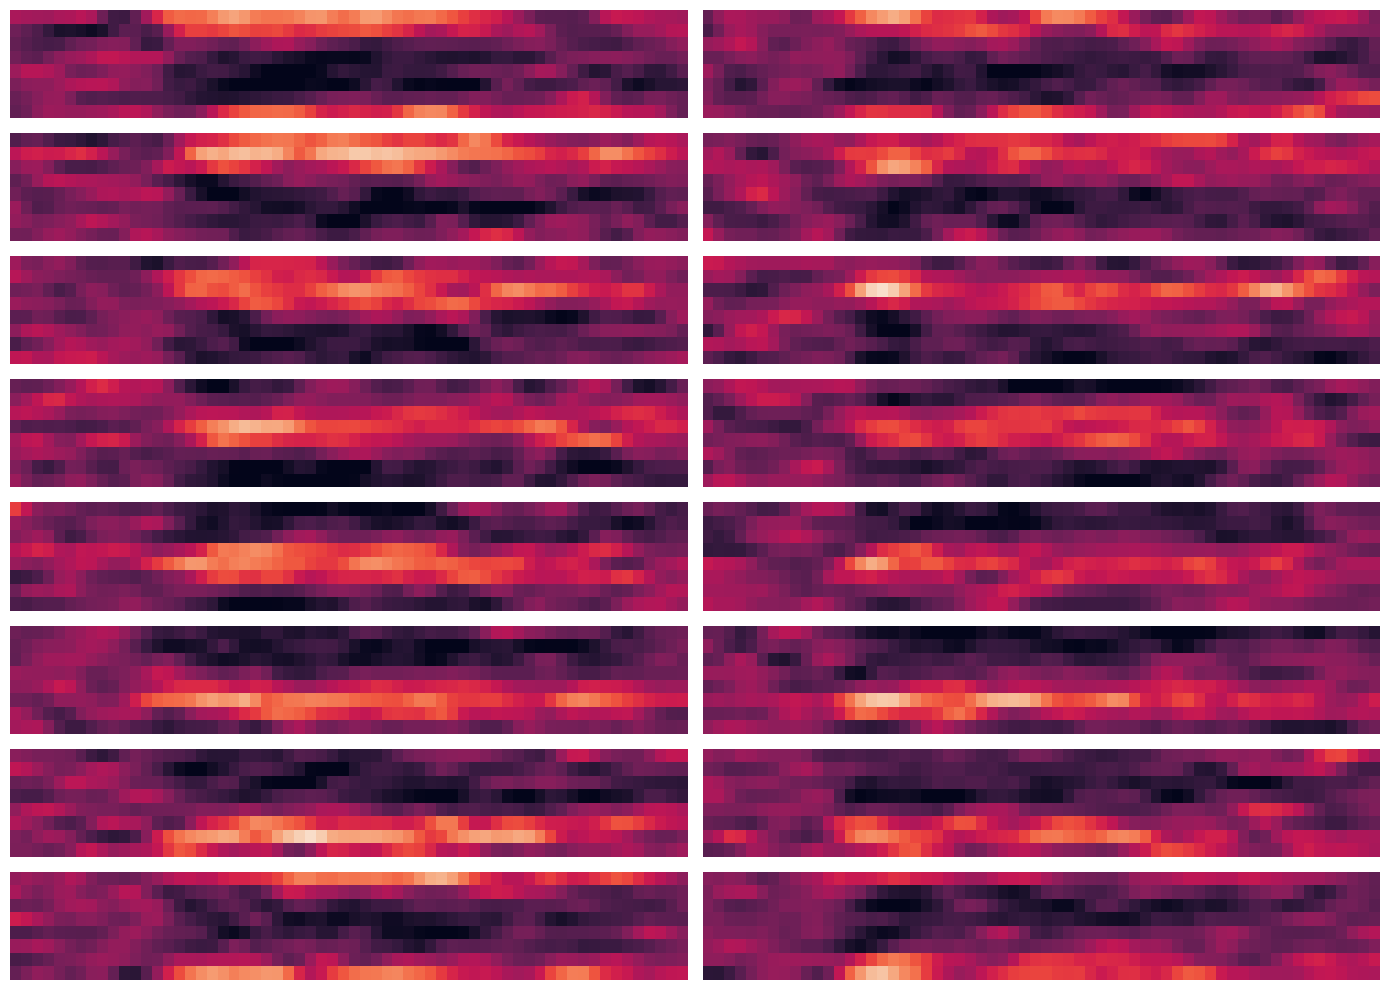

In [28]:
# make subplots that show the CTFs across time for the 8 locations (rows) and 2 conditions (columns)
fig, axes = plt.subplots(8, 2, figsize=(14, 10))
for loc in range(8):
    for cond in range(2):
        mean_loc_CTF_across_time = np.zeros((62, 8))
        for isub in width_results_noCentering:
            mean_loc_CTF_across_time += width_results_noCentering[isub]['tuneFuncs'][f'Cond{cond+1}'].mean(0).mean(1)[:,loc,:]
        mean_loc_CTF_across_time /= len(width_results_noCentering.keys())

        ax = sns.heatmap(mean_loc_CTF_across_time.T, cbar=False, vmin=0, vmax=.5, ax=axes[loc, cond])
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()
plt.close()

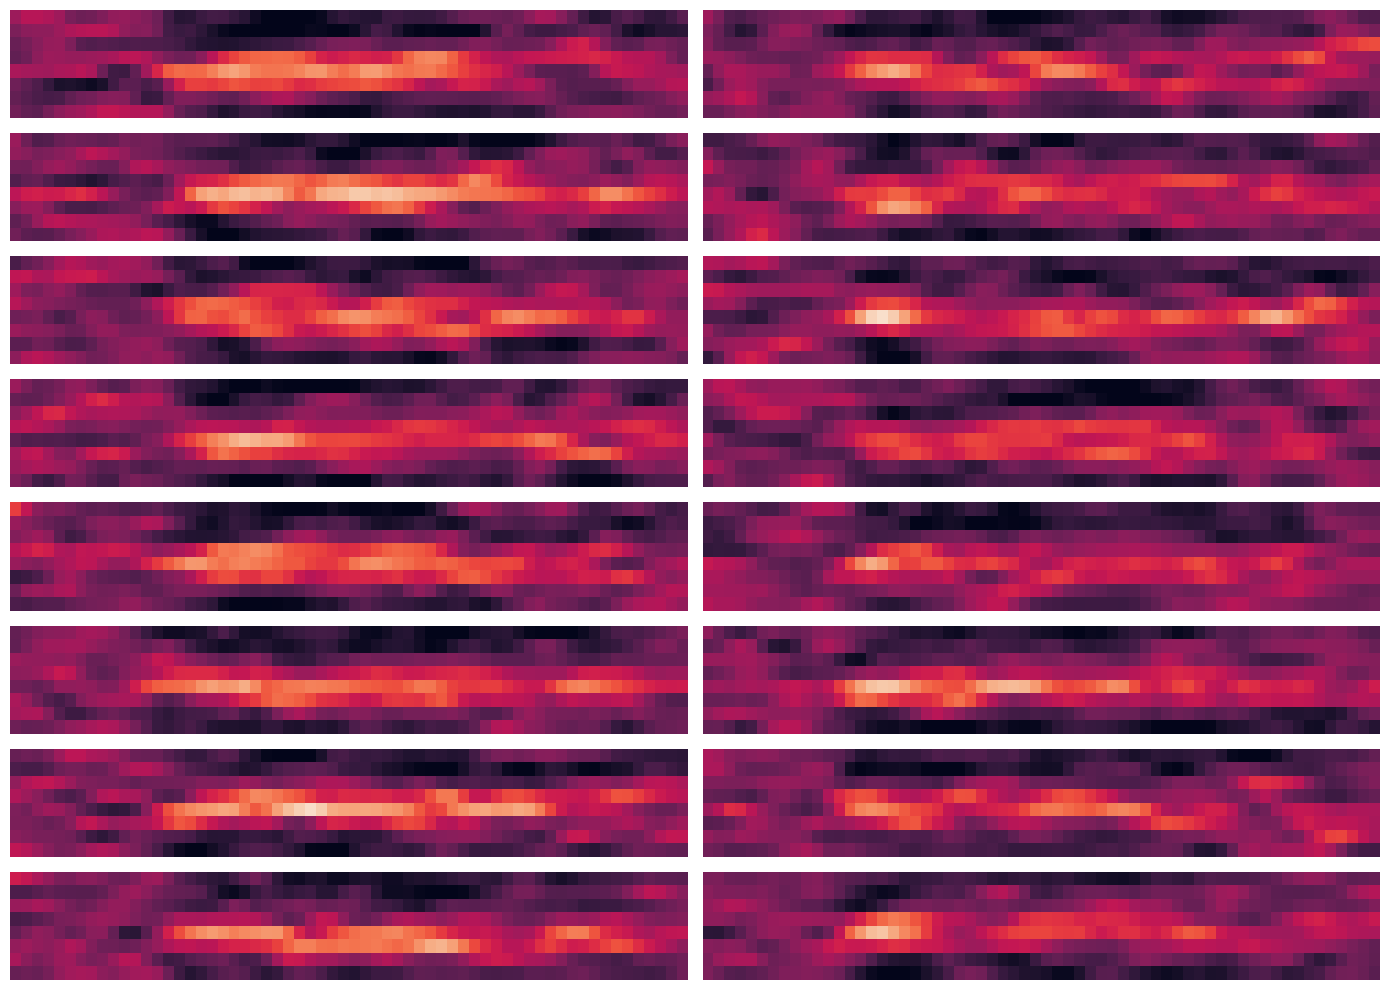

In [29]:
# make subplots that show the CTFs across time for the 8 locations (rows) and 2 conditions (columns)
# center them first for easy comparison
fig, axes = plt.subplots(8, 2, figsize=(14, 10))
for loc in range(8):
    for cond in range(2):
        mean_loc_CTF_across_time = np.zeros((62, 8))
        for isub in width_results_noCentering:
            sub_ctfs = width_results_noCentering[isub]['tuneFuncs'][f'Cond{cond+1}'].mean(0).mean(1)
            centered_ctfs = np.array([center_CTFs(sub_ctfs[t,:,:]) for t in range(sub_ctfs.shape[0])])
            mean_loc_CTF_across_time += centered_ctfs[:,loc,:]
        mean_loc_CTF_across_time /= len(width_results_noCentering.keys())

        ax = sns.heatmap(mean_loc_CTF_across_time.T, cbar=False, vmin=0, vmax=.5, ax=axes[loc, cond])
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()
plt.close()

In [30]:
central_v_lat_df = pd.DataFrame()
for isub in width_results_noCentering:
    sub_df = pd.DataFrame()
    for cond in range(2):
        broad_lateralized = np.zeros((62, 8))
        broad_central = np.zeros((62, 8))
        sub_ctfs = width_results_noCentering[isub]['tuneFuncs'][f'Cond{cond+1}'].mean(0).mean(1)
        centered_ctfs = np.array([center_CTFs(sub_ctfs[t,:,:]) for t in range(sub_ctfs.shape[0])])
        for loc in range(8):
            if loc in [0, 3, 4, 7]:
                broad_lateralized += centered_ctfs[:,loc,:]
            else:
                broad_central += centered_ctfs[:,loc,:]

        broad_lateralized /= 4
        broad_central /= 4
        
        broad_sub_df = pd.DataFrame(np.apply_along_axis(CTF_Slope, 1, broad_central))

        central_sub_df = pd.DataFrame(np.apply_along_axis(CTF_Slope, 1, broad_central), columns=['Slope'])
        central_sub_df['time'] = wrangl.t + 12.5
        central_sub_df['PID'] = isub
        central_sub_df['location'] = 'Centralized'
        central_sub_df['width'] = 'Narrow' if cond==0 else 'Broad'

        lat_sub_df = pd.DataFrame(np.apply_along_axis(CTF_Slope, 1, broad_lateralized), columns=['Slope'])
        lat_sub_df['time'] = wrangl.t + 12.5
        lat_sub_df['PID'] = isub
        lat_sub_df['location'] = 'Lateralized'
        lat_sub_df['width'] = 'Narrow' if cond==0 else 'Broad'

        cond_df = pd.concat([central_sub_df, lat_sub_df])
        sub_df = pd.concat([sub_df, cond_df])
    central_v_lat_df = pd.concat([central_v_lat_df, sub_df])

central_v_lat_df = central_v_lat_df.reset_index(drop=True)

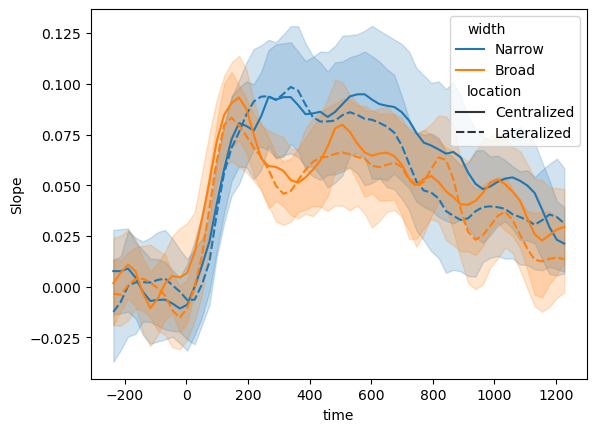

In [31]:
_ = sns.lineplot(x='time', y='Slope', hue='width', style='location', data=central_v_lat_df)
plt.savefig('RawFigures/SS1Breadth_CentralVLat.svg')

In [32]:
central_v_lat_summary = central_v_lat_df.query(f'(time > {250}) & (time <= {1150})').groupby(['PID', 'location', 'width']).mean().reset_index()
central_v_lat_summary

,PID,location,width,Slope,time
0,0,Centralized,Broad,0.074257,698.5
1,0,Centralized,Narrow,0.136655,698.5
2,0,Lateralized,Broad,0.089341,698.5
3,0,Lateralized,Narrow,0.046638,698.5
4,1,Centralized,Broad,0.104527,698.5
...,...,...,...,...,...
87,21,Lateralized,Narrow,0.146585,698.5
88,22,Centralized,Broad,0.014106,698.5
89,22,Centralized,Narrow,0.032637,698.5
90,22,Lateralized,Broad,0.024433,698.5


In [33]:
pg.rm_anova(dv='Slope', within=['location', 'width'], subject='PID', data=central_v_lat_summary, detailed=True, effsize='ng2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,location,0.001870,1,22,0.001870,3.018216,0.096316,0.096316,0.009489,1.0
1,width,0.006622,1,22,0.006622,10.978628,0.003160,0.003160,0.032800,1.0
2,location * width,0.000212,1,22,0.000212,0.651330,0.428277,0.428277,0.001082,1.0


In [34]:
central_v_lat_summary.to_csv('output/IEM_laterality_ANOVA.csv')

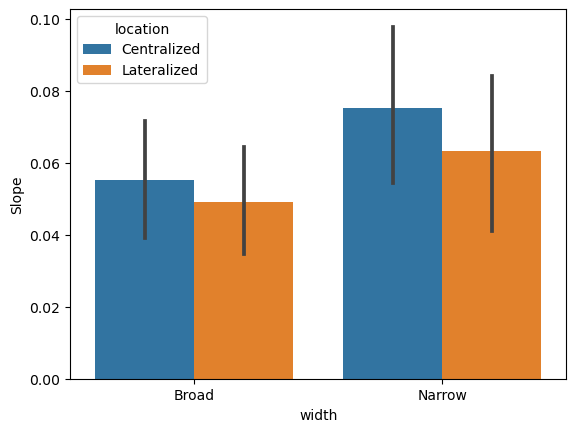

In [35]:
_ = sns.barplot(x='width', y='Slope', data=central_v_lat_summary, hue='location')  # will be recolored to align with slope plot above in illustrator
plt.savefig('RawFigures/SS1Breadth_CentralVLat_bar.svg')

# Area of Width 3 - Set Size 1 Broad vs 2 Superset

In [36]:
np.random.seed(2023)

In [37]:
matched_area_results = {}
for isub in range(exp.nsub):
    xdata = xdata_dict[isub]
    behavior = behavior_dict[isub]
    
    # GET AVERAGE OF EACH BIN FOR REMAINING 5 HYPERPLANE CONDITIONS
    held_out_cond_bins = {} 
    for cond in behavior.hyperplane_conditions.unique():
        if cond in [1, 4]:
            continue

        curr_loc  = behavior.hyperplane_conditions.isin([cond])
        curr_xdata = xdata[curr_loc, :, :]
        curr_xdata = curr_xdata[:,:,np.where(times_bool)[0]]
        curr_behavior = behavior.loc[curr_loc]
        curr_posLabels = curr_behavior.targetBin.values



        cond_bins = np.full((8, 30, 750), np.nan)
        for b in range(8):
            if np.sum(curr_posLabels==(b+1)):
                cond_bins[b] = curr_xdata[curr_posLabels==(b+1), :, :].mean(0)

        held_out_cond_bins[cond] = cond_bins
    
    
    # subset to SS1Broad and SS2Superset
    area3_loc = behavior.hyperplane_conditions.isin([1, 4])
    xdata = xdata[area3_loc, :, :]
    behavior = behavior.loc[area3_loc]
    
    # we always want the target to be the broad cloud
    posLabels = np.where(behavior.targetWidth==3, behavior.targetBin, behavior.otherBin)
    condLabels = behavior.SetSize.values
    print(Counter(condLabels))
    
    matched_area_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool, held_out=held_out_cond_bins)

Counter({1: 227, 2: 131})
Counter({1: 255, 2: 139})
Counter({1: 243, 2: 128})
Counter({1: 224, 2: 119})
Counter({1: 235, 2: 132})
Counter({1: 259, 2: 134})
Counter({1: 192, 2: 102})
Counter({1: 257, 2: 144})
Counter({1: 222, 2: 125})
Counter({1: 233, 2: 133})
Counter({1: 233, 2: 128})
Counter({1: 217, 2: 106})
Counter({1: 253, 2: 140})
Counter({1: 238, 2: 132})
Counter({1: 258, 2: 141})
Counter({1: 218, 2: 116})
Counter({1: 240, 2: 116})
Counter({1: 247, 2: 137})
Counter({1: 253, 2: 141})
Counter({1: 247, 2: 134})
Counter({1: 222, 2: 138})
Counter({1: 266, 2: 138})
Counter({1: 239, 2: 128})


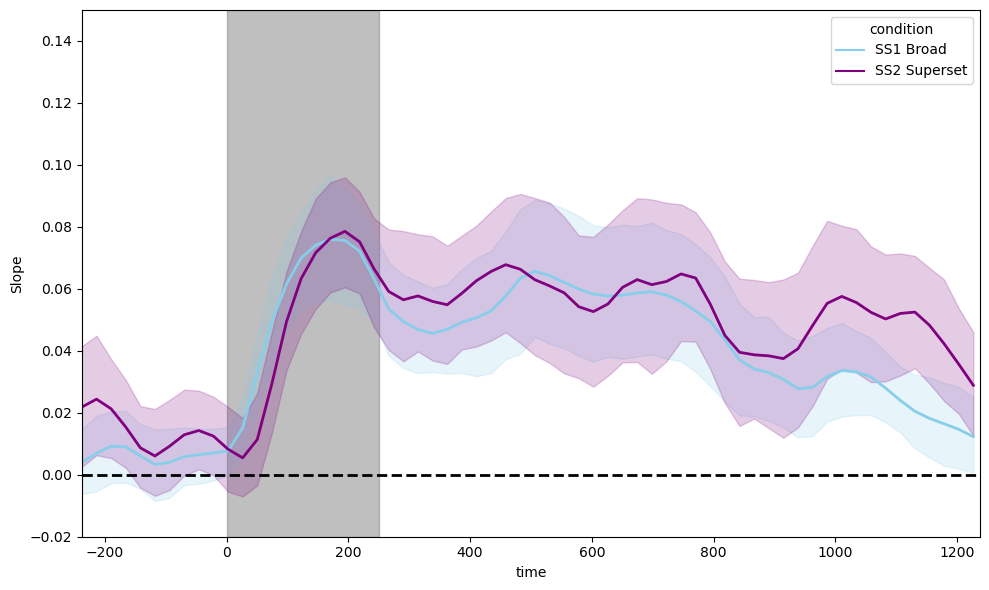

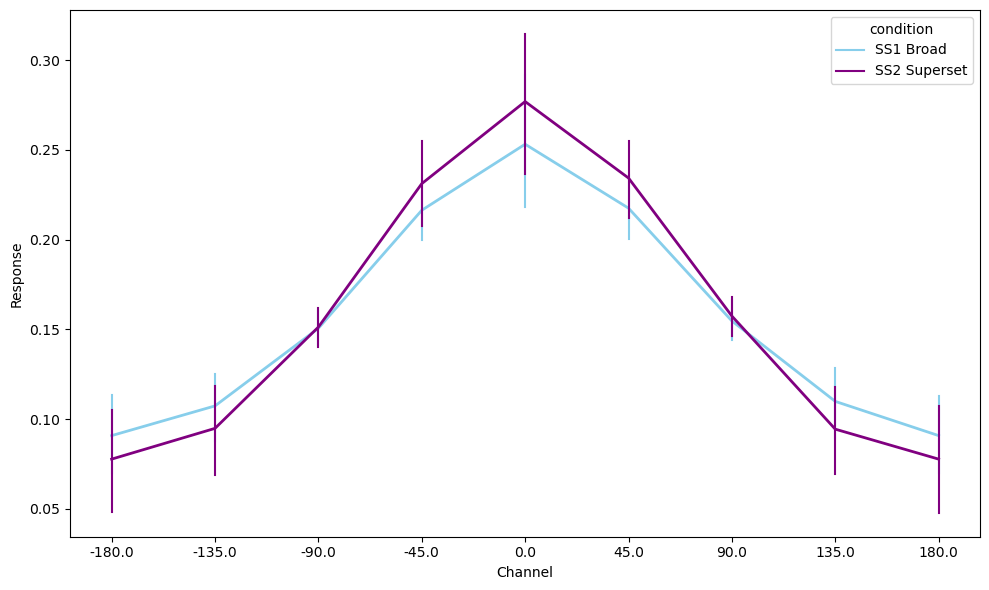

In [38]:
plot_results(matched_area_results, 'SS1 Broad', 'SS2 Superset', figname='IEM_SS1BroadvsSS2Superset', palette={'SS1 Broad': 'skyblue', 'SS2 Superset': 'purple'}, linewidth=2)

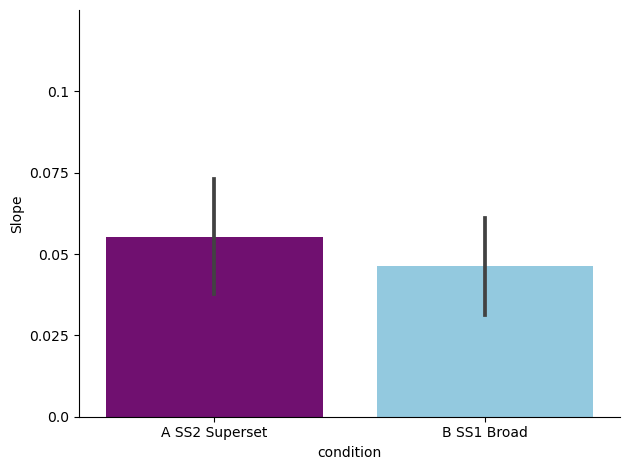

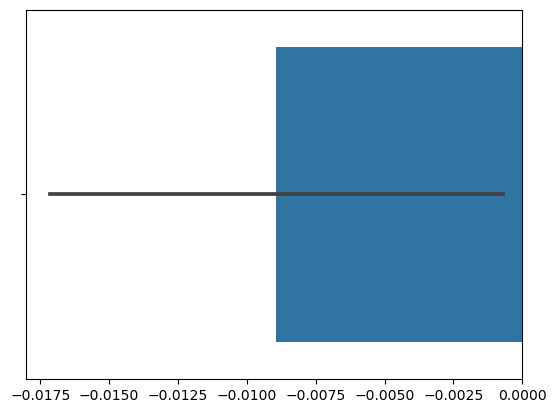

    Contrast               A            B  Paired  Parametric         T   dof  \
0  condition  A SS2 Superset  B SS1 Broad    True        True  2.041939  22.0   

  alternative     p-unc   BF10     cohen  
0   two-sided  0.053327  1.256  0.211902  


/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


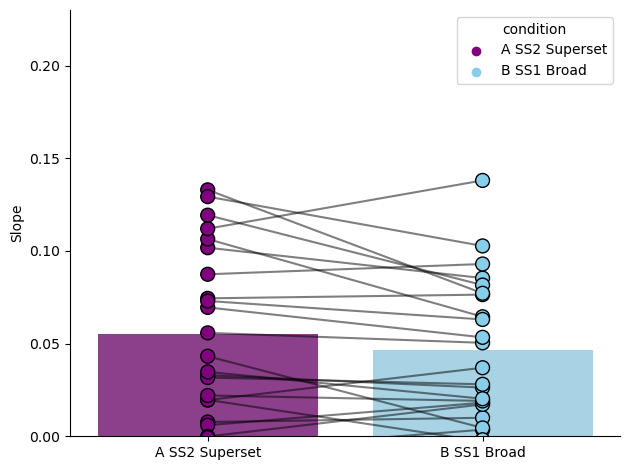

In [39]:
compare_delay_slopes(matched_area_results, 'B SS1 Broad', 'A SS2 Superset', figname='IEM_SS1BroadvsSS2Superset', palette={'B SS1 Broad': 'skyblue', 'A SS2 Superset': 'purple'})

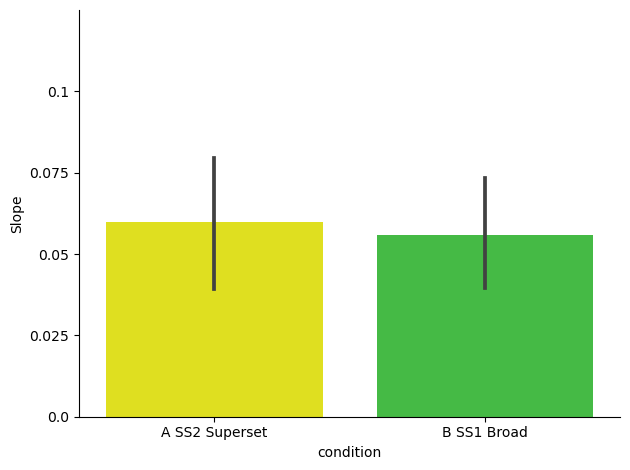

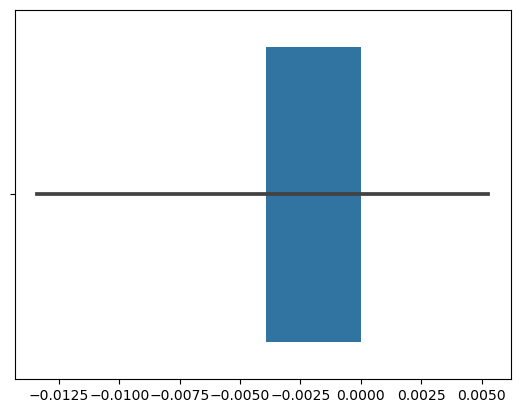

/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


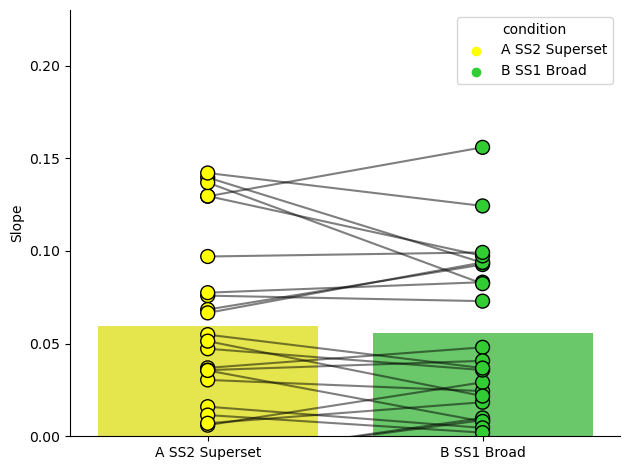

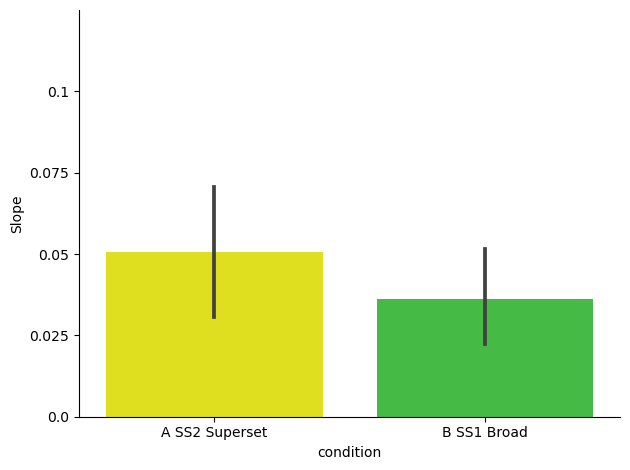

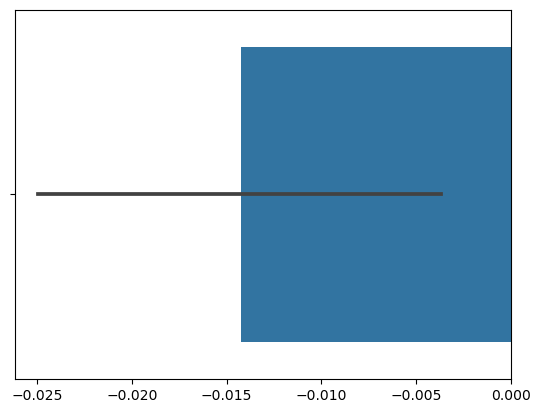

/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_95946/3029290014.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


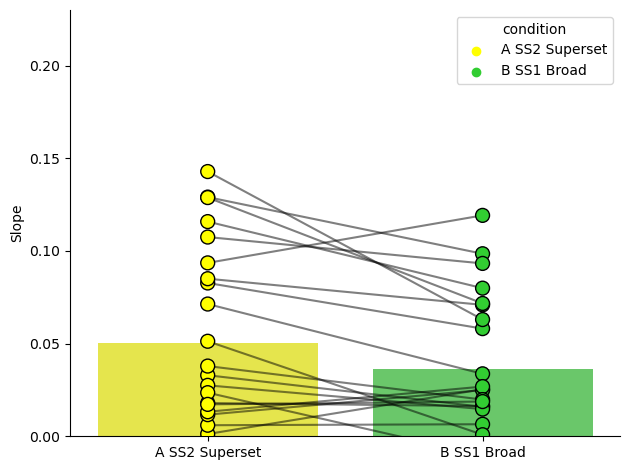

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,condition,0.001895,1,22,0.001895,4.279386,0.050529,0.050529,0.010295,1.0
1,delay_half,0.004731,1,22,0.004731,4.820890,0.038957,0.038957,0.025312,1.0
2,condition * delay_half,0.000610,1,22,0.000610,3.131192,0.090669,0.090669,0.003337,1.0


In [40]:
aov, post_hocs, summary_df = compare_slopes_across_delay_halves(matched_area_results, 'B SS1 Broad', 'A SS2 Superset', alternative='two-sided', figname='IEM_SS1Breadth', palette={'B SS1 Broad': 'limegreen', 'A SS2 Superset': 'yellow'})
summary_df.to_csv('output/IEM_delayHalf_ANOVA.csv')
aov

In [41]:
post_hocs

## Looking at the remaining hyper plane conditions to see their CTFs and slopes

In [42]:
held_out_CTF_df = pd.DataFrame()
held_out_slope_df = pd.DataFrame()
for isub in matched_area_results:
    sub_CTF_df = pd.DataFrame()
    sub_slope_df = pd.DataFrame()
    for heldOutCond in held_out_cond_bins:
        curr_CTF_df = pd.DataFrame()
        curr_CTF_df['Response'] = matched_area_results[isub]['tuneFuncs']['held_out'][heldOutCond].mean(0).mean(1)[wrangl.t > 250, :].mean(0)
        curr_CTF_df['Channel'] = np.arange(1,9)
        curr_CTF_df['PID'] = isub
        curr_CTF_df['condition'] = heldOutCond
        sub_CTF_df = pd.concat([sub_CTF_df, curr_CTF_df])
        
        curr_slope_df = pd.DataFrame()
        curr_slope_df['time'] = wrangl.t
        curr_slope_df['Slope'] = matched_area_results[isub]['slope']['held_out'][heldOutCond].mean(0).mean(1)
        curr_slope_df['PID'] = isub
        curr_slope_df['condition'] = heldOutCond
        sub_slope_df = pd.concat([sub_slope_df, curr_slope_df])
        
    held_out_CTF_df = pd.concat([held_out_CTF_df, sub_CTF_df])
    held_out_slope_df = pd.concat([held_out_slope_df, sub_slope_df])

wraparound = held_out_CTF_df.query('Channel==1').copy()
wraparound['Channel'] = 9
held_out_CTF_df = pd.concat([held_out_CTF_df, wraparound]).reset_index(drop=True)

held_out_CTF_df.condition = held_out_CTF_df.condition.map(hyperplane_conds)
held_out_slope_df.condition = held_out_slope_df.condition.map(hyperplane_conds)

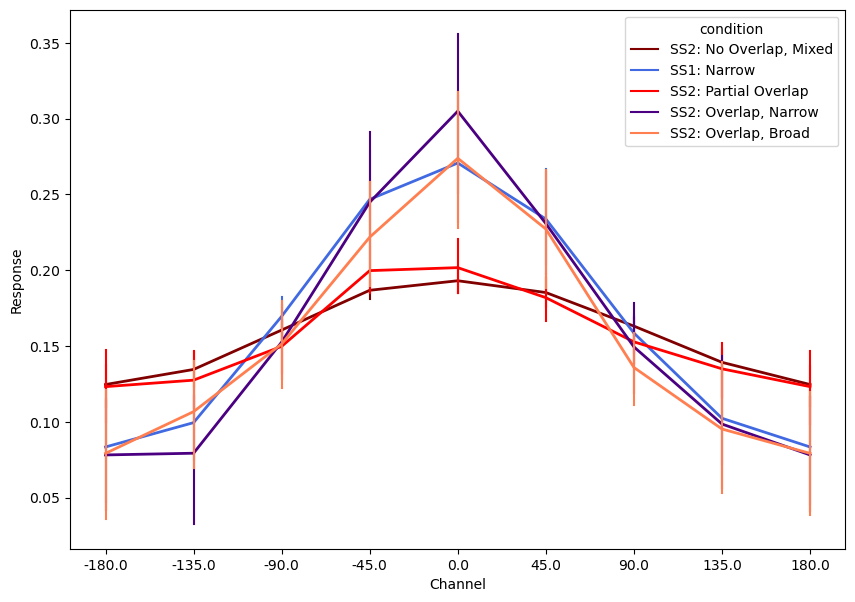

In [43]:
plt.figure(figsize=(10,7))
ax = sns.lineplot(x='Channel', y='Response', hue='condition', data=held_out_CTF_df, err_style='bars', linewidth=2, palette=palette)
ax.set_xticks(np.arange(1, 10))
_ = ax.set_xticklabels(np.linspace(-180, 180, 9))

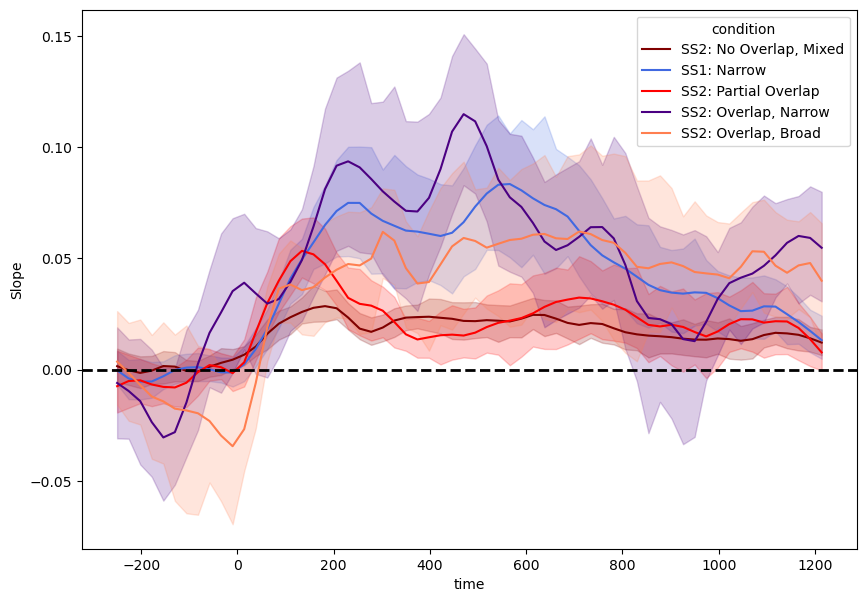

In [44]:
plt.figure(figsize=(10,7))
ax = sns.lineplot(x='time', y='Slope', hue='condition', data=held_out_slope_df.reset_index(drop=True), palette=palette, n_boot=100)
_ = ax.axhline(y=0, color='k', linestyle='--', linewidth=2)

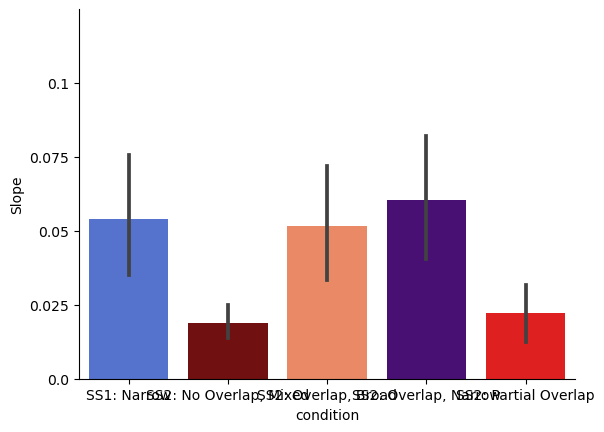

In [45]:
slope_summary = held_out_slope_df.query('(time > 250) & (time <= 1150)').groupby(['PID', 'condition']).mean().reset_index()
ax = sns.barplot(x='condition', y='Slope', data=slope_summary, palette=palette)
ax.set_ylim([0, .125])
ax.set_yticks(np.arange(0, .125, .025))
ax.set_yticklabels(np.round(np.arange(0, .125, .025), 3))

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

## combine and save for bayesian modeling approach

In [46]:
full_CTF_df = pd.DataFrame()
for isub in matched_area_results:
    sub_CTF_df = pd.DataFrame()
    
    # Condition that the participant was trained on
    for cond, condname in [('Cond1', 'SS1: Broad'), ('Cond2', 'SS2: Superset')]:
        curr_CTF_df = pd.DataFrame(matched_area_results[isub]['tuneFuncs'][cond].mean(0).mean(1))
        curr_CTF_df['timepoint'] = wrangl.t + 17.5
        curr_CTF_df = pd.melt(curr_CTF_df, id_vars=['timepoint'], value_vars=np.arange(8), var_name='channel_bin', value_name='response')
        curr_CTF_df['PID'] = isub
        curr_CTF_df['condition'] = condname
        sub_CTF_df = pd.concat([sub_CTF_df, curr_CTF_df])
    
    # held out conditions
    for heldOutCond in held_out_cond_bins:
        curr_CTF_df = pd.DataFrame(matched_area_results[isub]['tuneFuncs']['held_out'][heldOutCond].mean(0).mean(1))
        curr_CTF_df['timepoint'] = wrangl.t + 17.5
        curr_CTF_df = pd.melt(curr_CTF_df, id_vars=['timepoint'], value_vars=np.arange(8), var_name='channel_bin', value_name='response')
        curr_CTF_df['PID'] = isub
        curr_CTF_df['condition'] = hyperplane_conds[heldOutCond]
        sub_CTF_df = pd.concat([sub_CTF_df, curr_CTF_df])
        
    full_CTF_df = pd.concat([full_CTF_df, sub_CTF_df])
        
full_CTF_df = full_CTF_df.reset_index(drop=True)

In [47]:
full_CTF_df.query('PID==6 and condition=="SS2: Overlap, Narrow"')

,timepoint,channel_bin,response,PID,condition
23312,-232.5,0,NaN,6,"SS2: Overlap, Narrow"
23313,-208.5,0,NaN,6,"SS2: Overlap, Narrow"
23314,-184.5,0,NaN,6,"SS2: Overlap, Narrow"
23315,-160.5,0,NaN,6,"SS2: Overlap, Narrow"
23316,-136.5,0,NaN,6,"SS2: Overlap, Narrow"
...,...,...,...,...,...
23803,1135.5,7,NaN,6,"SS2: Overlap, Narrow"
23804,1159.5,7,NaN,6,"SS2: Overlap, Narrow"
23805,1183.5,7,NaN,6,"SS2: Overlap, Narrow"
23806,1207.5,7,NaN,6,"SS2: Overlap, Narrow"


In [48]:
full_CTF_df.to_csv('full_ctf_response_estimates.csv')

In [49]:
full_CTF_df[full_CTF_df.response.isnull()].PID.unique()

array([6])

### Diagnose missing data in one sub

In [50]:
isub = 6

xdata = xdata_dict[isub]
behavior = behavior_dict[isub]

cond = 2

curr_loc  = behavior.hyperplane_conditions.isin([cond])
curr_xdata = xdata[curr_loc, :, :]
curr_xdata = curr_xdata[:,:,np.where(times_bool)[0]]
curr_behavior = behavior.loc[curr_loc]
curr_posLabels = curr_behavior.targetBin.values



cond_bins = np.full((8, 30, 750), np.nan)
for b in range(8):
    if np.sum(curr_posLabels==(b+1)):
        cond_bins[b] = curr_xdata[curr_posLabels==(b+1), :, :].mean(0)

held_out_cond_bins[cond] = cond_bins

print(curr_xdata[curr_posLabels==(2+1), :, :])

held_out_cond_bins[2][2] # bin 2 bad

[]


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])